In [10]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb

In [49]:
companies = [
    "NFLX", "TSLA", "ORCL", "CSCO", "CRM", "ADBE", "SNPS", "INTC", "AAPL", "MSFT", "GOOGL", "META", "AMZN",
    "QCOM", "TXN", "AMAT", "NOW", "RNG", "HPE", "NVDA", "AMD", "IBM", "INTU", "LRCX", "MU", "ADSK", "PLTR", 
    "ZS", "PANW", "SNOW", "DDOG", "CRWD", "V", "MA", "C", "JPM", "WFC", "TROW", "SCHW", "CME", "MSCI", 
    "PYPL", "SQ", "SHOP", "AXP", "GS", "MS", "SPGI", "BLK", "BAC", "NKE", "LULU", "TJX", "COST", "HD", "LOW",
    "TGT", "WMT", "BBY", "F", "GM", "DE", "RCL", "UAL", "DAL", "AAL", "BKNG", "MAR", "HLT", "JNJ", "PFE", 
    "MRK", "AMGN", "ABBV", "CVS", "GSK", "AZN", "BMY", "LLY", "GILD", "MRNA", "REGN", "TMO", "ISRG", "SYK", 
    "BDX", "DHR", "KO", "PEP", "PG", "CLX", "CAG", "SJM", "CPB", "DIS", "EA", "MO", "CL", "EL", "KHC", 
    "UL", "NSRGY", "COTY", "MCD", "YUM", "SBUX", "DASH", "WBA", "XOM", "CVX", "SLB", "OXY", "PXD", "COP", 
    "BKR", "VLO", "PSX", "APD", "LIN", "DOW", "DD", "SHW", "PPG", "NOC", "LMT", "GD", "RTX", "BA", "GE", 
    "CAT", "MMM", "HON", "ITW", "EMR", "DHR", "UNH", "CI", "HUM", "ANTM", "CNC"
]

data = pd.DataFrame()


In [31]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [57]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low', 'Close']
       technical_indicators = ['SMA15', 'EMA5', 'RSI15', 'BB_upper', 'ATR', 'MACD', 'OBV', 'CMF']
       volume_column = 'Volume'
       
       for col in price_columns:
              uncscaled_data = remove_outliers(uncscaled_data, col)
       
       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()
       standard_scaler_close = StandardScaler()

       price_columns.pop()

       uncscaled_data[price_columns] = standard_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = standard_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [58]:
def calculate_tech_ind(curr, data):
    # Trend Indicators
    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Short-term Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Short-term Exponential Moving Average
    
    # Momentum Indicators
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
    
    # Volatility Indicators
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=20, std=2).iloc[:, [0, 2]].T.values  # Bollinger Bands
    data['ATR'] = ta.atr(curr['High'], curr['Low'], curr['Close'], length=14)  # Average True Range
    
    # Volume Indicators
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])  # On-Balance Volume
    data['CMF'] = ta.ad(curr['High'], curr['Low'], curr['Close'], curr['Volume']) / ta.sma(curr['Volume'], length=20)  # Chaikin Money Flow
    
    # Additional: Ichimoku Cloud and Percentage Price Oscillator (PPO)
    #ichimoku_df, _ = ta.ichimoku(curr['High'], curr['Low'], curr['Close'])
    #data['Ichimoku_base'] = ichimoku_df['ISB_26']
    # ppo_values = ta.ppo(curr['Close'])  # Percentage Price Oscillator
    # data['PPO'] = ppo_values['PPO']

    # Clean and Scale Data
    uncleaned_data = pd.concat([curr, data], axis=0)
    uncleaned_data = uncleaned_data.iloc[14:, :]  # Discard initial rows to avoid NaNs
    uncleaned_data.fillna(method='ffill', inplace=True)
    uncleaned_data.fillna(method='bfill', inplace=True)

    scaled_data = scale_data(uncleaned_data)

    return scaled_data


In [59]:
for i in companies:
    try:

        curr = yf.download(i, period="max")

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD']

Input X contains infinity or a value too large for dtype('float64'). UL


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD']

'NoneType' object has no attribute 'iloc' PXD


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD']

'NoneType' object has no attribute 'iloc' ANTM


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_11736\4188463515.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values  # MACD and Signal Line


In [60]:
scaled_data = data

In [61]:
def print_column_ranges(data):
    for col in data.columns:
        col_min = data[col].min()
        col_max = data[col].max()
        col_range = col_max - col_min
        print(f"{col}: Min = {col_min}, Max = {col_max}, Range = {col_range}")

print_column_ranges(data)


Adj Close: Min = 0.0015667467378079891, Max = 4749.10986328125, Range = 4749.108296534512
Close: Min = 0.00520800007507205, Max = 4749.10986328125, Range = 4749.104655281175
High: Min = -106.08487168300584, Max = 8.164101763855808, Range = 114.24897344686165
Low: Min = -106.08487168300708, Max = 3.4816624068081645, Range = 109.56653408981525
Open: Min = -106.08487168300661, Max = 53.03403314307299, Range = 159.11890482607959
Volume: Min = -46.171791703801766, Max = 106.08487168300552, Range = 152.25666338680728
SMA15: Min = -3.5303223638530534, Max = 9.738723934170357, Range = 13.269046298023412
EMA5: Min = -3.6062192213643605, Max = 9.741807012482319, Range = 13.34802623384668
RSI15: Min = -5.323595419071138, Max = 5.11550997149806, Range = 10.439105390569198
MACD: Min = -29.846782562215562, Max = 18.024529389835216, Range = 47.871311952050775
MACD_signal: Min = -72.15889841588559, Max = 49.63156889633965, Range = 121.79046731222525
BB_upper: Min = -3.9168522787142037, Max = 10.071843

In [62]:
scaled_data.shape

(2425410, 16)

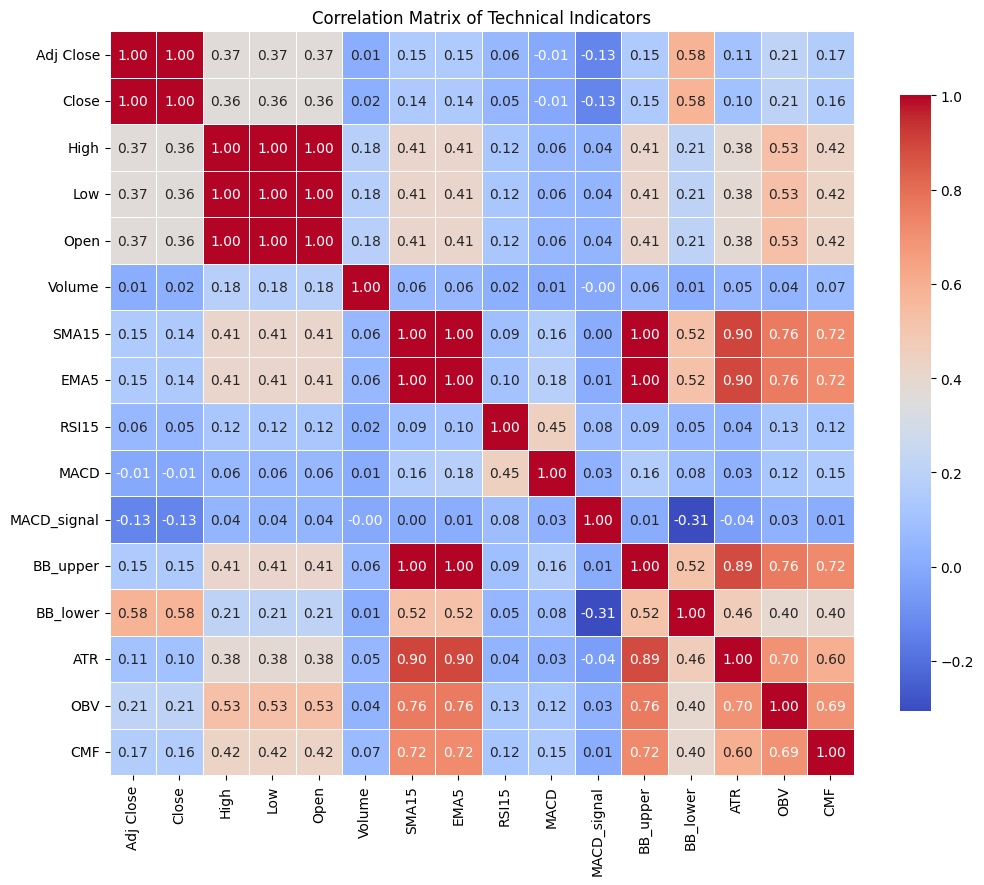

In [63]:
correlation_matrix = scaled_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


In [64]:
target_classification = (scaled_data['Close'].shift(-1) > scaled_data['Close']).astype(int)

In [65]:
input = scaled_data.drop(columns=['Low', 'Open','SMA15', 'BB_lower', 'BB_upper', 'Adj Close', 'Close', 'OBV'])

In [66]:
print(input.shape)
print(target_classification.shape)

(2425410, 8)
(2425410,)


In [67]:
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(input, target_classification, test_size=0.2, random_state=42)

In [68]:
print(X_train_cal.shape, y_train_cal.shape)

(1940328, 8) (1940328,)


In [69]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix

# Updated model architecture
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_cal.shape[1],)),
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile with binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_cal, y_train_cal, epochs=100, batch_size=32, validation_split=0.2)

# Predictions and evaluation
y_pred_prob = model.predict(X_test_cal)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Threshold for classification

# Calculate accuracy
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

# Optional: View results and confusion matrix
results = pd.DataFrame({
    'Actual': y_test_cal,
    'Predicted': y_pred.flatten()
})
print(results.head())

conf_matrix = confusion_matrix(y_test_cal, y_pred)
print("Confusion Matrix:\n", conf_matrix)


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
48509/48509 [==============================] - 158s 3ms/step - loss: 0.3478 - accuracy: 0.7691 - val_loss: 0.3397 - val_accuracy: 0.7699
Epoch 2/100
48509/48509 [==============================] - 157s 3ms/step - loss: 0.3426 - accuracy: 0.7697 - val_loss: 0.3396 - val_accuracy: 0.7703
Epoch 3/100
48509/48509 [==============================] - 156s 3ms/step - loss: 0.3422 - accuracy: 0.7698 - val_loss: 0.3391 - val_accuracy: 0.7700
Epoch 4/100
48509/48509 [==============================] - 156s 3ms/step - loss: 0.3417 - accuracy: 0.7693 - val_loss: 0.3385 - val_accuracy: 0.7699
Epoch 5/100
48509/48509 [==============================] - 156s 3ms/step - loss: 0.3418 - accuracy: 0.7693 - val_loss: 0.3385 - val_accuracy: 0.7689
Epoch 6/100
48509/48509 [==============================] - 156s 3ms/step - loss: 0.3413 - accuracy: 0.7691 - val_loss: 0.3376 - val_accuracy: 0.7699
Epoch 7/100
48509/48509 [==============================] - 155s 3ms/step - loss: 0.3408 - accuracy: 0.7693